In [1]:
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import Models
import utils

In [2]:
X_train, X_test, y_train, y_test = utils.load_mnist()

In [3]:
X_train = X_train / 255.
X_test = X_test / 255.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(35700, 28, 28) (6300, 28, 28) (35700,) (6300,)


Label:  1


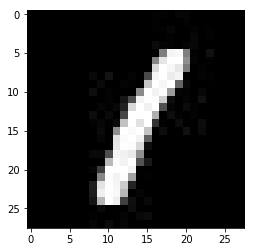

In [5]:
print('Label: ', y_train[30000])
plt.imshow(X_train[30000], cmap='gray')
plt.show()

In [6]:
iterate_minibatches = Models.iterate_minibatches
compute_loss = Models.compute_loss
Flatten = Models.Flatten
Radamacher_Regularization_p_inf_q_1 = Models.Radamacher_Regularization_p_inf_q_1
VariationalDropout = Models.VariationalDropout
ComplexModel = Models.ComplexModel

In [7]:
X_train = torch.Tensor(X_train ).cuda()
y_train = torch.tensor(y_train).cuda()

X_val = torch.Tensor(X_val).cuda()
y_val = torch.tensor(y_val).cuda()

X_test = torch.Tensor(X_test).cuda()
y_test = torch.tensor(y_test).cuda()

In [8]:
num_epochs = 150
batch_size = 100

regularizer_weights = 1e-3

n_optimization_iter_to_upd_lr = 40
multiplicative_factor_lr = 0.5

learning_rate = 1e-2

In [9]:
model = nn.Sequential(Flatten(), 
                      torch.nn.Linear(784, 1024),
                      VariationalDropout(torch.Tensor([0.8] * 1024).cuda(), 'deterministic'),
                      torch.nn.ReLU(), 
                      torch.nn.Linear(1024, 10), 
                     )
model.cuda()

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_optimization_iter_to_upd_lr,
                                            gamma=multiplicative_factor_lr)

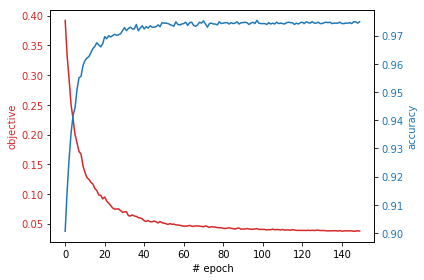

In [10]:
complex_1024 = ComplexModel(model, X_train, y_train, X_val, y_val, num_epochs, batch_size, optimizer, scheduler, 
                            Radamacher_Regularization_p_inf_q_1, regularizer_weights, random_seed = 123)

complex_1024_loss, complex_1024_extra_loss, complex_1024_val_accuracy = complex_1024.train()
complex_1024.plot()

In [11]:
complex_1024_test_acc = complex_1024.test(X_val, y_val)

Final results:
Test accuracy:		97.48 %


In [12]:
model_2_800 = nn.Sequential(Flatten(), 
                      torch.nn.Linear(784, 800),
                      VariationalDropout(torch.Tensor([0.8] * 800).cuda(), 'deterministic'),
                      torch.nn.ReLU(),
                      torch.nn.Linear(800, 800),
                      VariationalDropout(torch.Tensor([0.8] * 800).cuda(), 'deterministic'),
                      torch.nn.ReLU(), 
                      torch.nn.Linear(800, 10), 
                     )
model_2_800.cuda()

optimizer = torch.optim.SGD(model_2_800.parameters(), momentum=0.9, lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_optimization_iter_to_upd_lr,
                                            gamma=multiplicative_factor_lr)

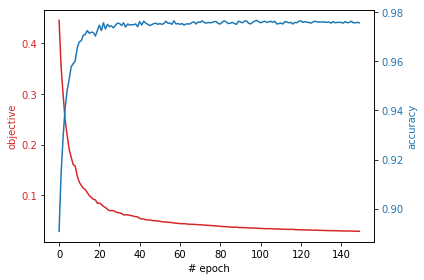

In [13]:
complex_2_800 = ComplexModel(model_2_800, X_train, y_train, X_val, y_val, num_epochs, batch_size, 
                            optimizer, scheduler, 
                            Radamacher_Regularization_p_inf_q_1, regularizer_weights, random_seed = 123)

complex_2_800_loss, complex_2_800_extra_loss, complex_2_800_val_accuracy = complex_2_800.train()
complex_2_800.plot()

In [14]:
complex_2_800_test_acc = complex_2_800.test(X_val, y_val)

Final results:
Test accuracy:		97.54 %


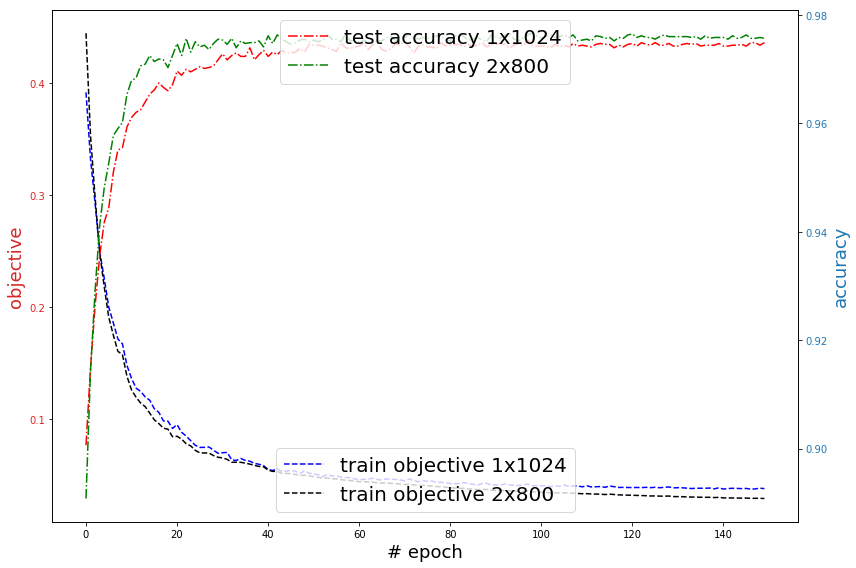

In [15]:
fig, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:red'
ax1.set_xlabel('# epoch', size=18)
ax1.set_ylabel('objective', color=color, size=18)
ax1.plot(np.array(complex_1024_loss) + regularizer_weights *np.array(complex_1024_extra_loss), linestyle='--', label='train objective 1x1024', c='blue')
ax1.plot(np.array(complex_2_800_loss) + regularizer_weights *np.array(complex_2_800_extra_loss), linestyle='--', label='train objective 2x800', c='black')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(prop={'size': 20},loc=8)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color, size=18)  # we already handled the x-label with ax1
ax2.plot(complex_1024_val_accuracy, linestyle='-.', label='test accuracy 1x1024', c='red')
ax2.plot(complex_2_800_val_accuracy, linestyle='-.', label='test accuracy 2x800', c='green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(prop={'size': 20}, loc=9)
plt.show()